# 💾 📊 Fund Data - Ranking and returns 📊 💾

In [32]:
import pandas as pd

import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
import numpy as np

In [2]:
myCSVfile = ("merged.csv")
mergedDF = pd.read_csv(myCSVfile)
mergedDF.head()

,Unnamed: 0,Month of Date,Year of Date,Month Number,ETF,Sponsor,Sponsor Category,CIFSC,Fund Name,Net Assets,Gross Sales,Redemptions
0,0,January 2016,2016,1,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,183094000.0,937000.0,2397000.0
1,1,February 2016,2016,2,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,172025000.0,812000.0,1825000.0
2,2,March 2016,2016,3,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,172097000.0,604000.0,1880000.0
3,3,April 2016,2016,4,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,168156000.0,273310.0,1843800.0
4,4,May 2016,2016,5,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,177464000.0,516000.0,1638000.0


In [63]:
# to get the monthly returns, you have to do "Net Asset_(i+1),f" / ("Net Asset_i,f" + ("Gross Sales_(i+1),f - Redemptions_(i+1),f") )
# Add a column with the consolidated CIFSC
import duckdb

# Register both dataframes
duckdb.register("mergedDF", mergedDF)


query = """
WITH computed_returns AS (
  SELECT
    "Fund Name",
    "Month of Date",
    "Year of Date",
    "Month Number",
    "ETF",
    "Sponsor",
    "Sponsor Category",
    "CIFSC",
    "Fund Name",
    "Net Assets",
    "Gross Sales",
    "Redemptions",
    CASE
      WHEN LAG("Net Assets") OVER (PARTITION BY "Fund Name" ORDER BY "Month Number") IS NULL 
        THEN 0
      ELSE "Net Assets" / (LAG("Net Assets") OVER (PARTITION BY "Fund Name" ORDER BY "Month Number")
                            + ("Gross Sales" - "Redemptions"))
    END AS monthly_return
  FROM mergedDF
)
SELECT
  *,
  CASE
    WHEN monthly_return < 0.6 OR monthly_return > 1.5 THEN NULL
    ELSE monthly_return
  END AS monthly_return_filtered
FROM computed_returns;
"""

monthly_returns = duckdb.query(query).to_df()
monthly_returns.head()


,Fund Name,Month of Date,Year of Date,Month Number,ETF,Sponsor,Sponsor Category,CIFSC,Fund Name_1,Net Assets,Gross Sales,Redemptions,monthly_return,monthly_return_filtered
0,Sun Life Granite Growth Portfolio,March 2022,2022,75,N,Sun Life,Life Insurers,Global Equity Balanced,Sun Life Granite Growth Portfolio,1.594978e+09,22153600.0,14826920.0,1.006235,1.006235
1,Sun Life Granite Growth Portfolio,April 2022,2022,76,N,Sun Life,Life Insurers,Global Equity Balanced,Sun Life Granite Growth Portfolio,1.515673e+09,11669720.0,11837250.0,0.950379,0.950379
2,Sun Life Granite Growth Portfolio,May 2022,2022,77,N,Sun Life,Life Insurers,Global Equity Balanced,Sun Life Granite Growth Portfolio,1.507985e+09,10361050.0,10463140.0,0.994994,0.994994
3,Sun Life Granite Growth Portfolio,June 2022,2022,78,N,Sun Life,Life Insurers,Global Equity Balanced,Sun Life Granite Growth Portfolio,1.417422e+09,11454580.0,13506490.0,0.941225,0.941225
4,Sun Life Granite Growth Portfolio,July 2022,2022,79,N,Sun Life,Life Insurers,Global Equity Balanced,Sun Life Granite Growth Portfolio,1.488142e+09,10646710.0,8932270.0,1.048625,1.048625


In [64]:
print(monthly_returns.columns)

Index(['Fund Name', 'Month of Date', 'Year of Date', 'Month Number', 'ETF',
       'Sponsor', 'Sponsor Category', 'CIFSC', 'Fund Name_1', 'Net Assets',
       'Gross Sales', 'Redemptions', 'monthly_return',
       'monthly_return_filtered'],
      dtype='object')


In [70]:
import duckdb

# Register both dataframes
duckdb.register("monthly_returns", monthly_returns)


query = """
SELECT
  *,
  AVG("monthly_return_filtered") OVER (PARTITION BY "CIFSC", "Month Number") AS avg_return_for_cat
FROM monthly_returns
ORDER BY "Fund Name_1" ASC, "Month Number" ASC;
"""

monthly_returns01 = duckdb.query(query).to_df()
monthly_returns01.iloc[17500:17505]


,Fund Name,Month of Date,Year of Date,Month Number,ETF,Sponsor,Sponsor Category,CIFSC,Fund Name_1,Net Assets,Gross Sales,Redemptions,monthly_return,monthly_return_filtered,avg_return_for_cat
17500,BMO Covered Call Health Care ETF,August 2023,2023,92,Y,BMO,Banks,Sector Equity,BMO Covered Call Health Care ETF,10039060.0,2902990.0,0.0,1.001901,1.001901,0.995759
17501,BMO Covered Call Health Care ETF,September 2023,2023,93,Y,BMO,Banks,Sector Equity,BMO Covered Call Health Care ETF,9751460.0,1435740.0,1435740.0,0.971352,0.971352,0.948804
17502,BMO Covered Call Health Care ETF,October 2023,2023,94,Y,BMO,Banks,Sector Equity,BMO Covered Call Health Care ETF,12374820.0,2796230.0,0.0,0.986223,0.986223,0.968722
17503,BMO Covered Call Health Care ETF,November 2023,2023,95,Y,BMO,Banks,Sector Equity,BMO Covered Call Health Care ETF,12488780.0,0.0,0.0,1.009209,1.009209,1.087322
17504,BMO Covered Call Health Care ETF,December 2023,2023,96,Y,BMO,Banks,Sector Equity,BMO Covered Call Health Care ETF,11185940.0,0.0,1407210.0,1.009418,1.009418,1.043638


c:\Users\AzureVirtualDesktopU\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


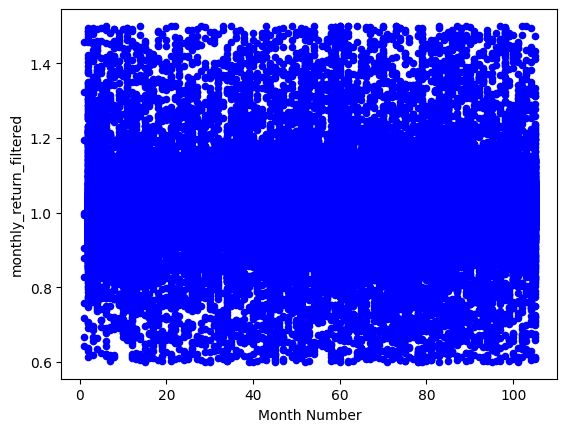

In [73]:
scatter = monthly_returns01.plot.scatter(x = "Month Number", y = "monthly_return_filtered", c='blue', colormap='viridis')
# plt.show()

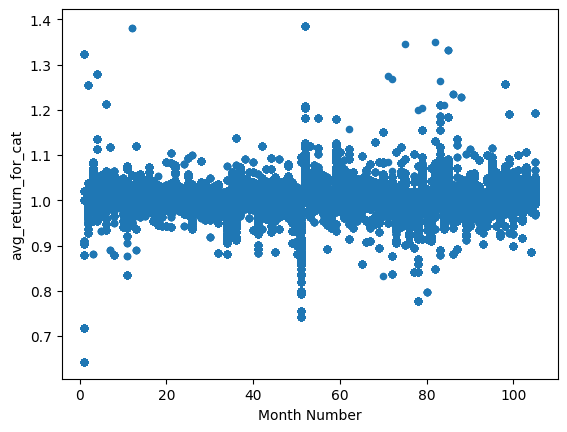

In [67]:
scatter1 = monthly_returns01.plot.scatter(x = "Month Number", y = "avg_return_for_cat")

In [69]:
monthly_returns01["avg_return_for_cat"].describe()

count    453346.000000
mean          1.005709
std           0.032370
min           0.642615
25%           0.991710
50%           1.006301
75%           1.022463
max           1.385557
Name: avg_return_for_cat, dtype: float64